## Lab 2: Malware analysis using VirusTotal reports on malware samples

### Objectives of the lab:
   - See where to extract MD5 hashes from and use them to access VirusTotal API – obtain reports on the malware samples.
   - Learn about various attributes of malwares that would be used to characterize the samples based on their families or types
   - Learn how to convert various attributes of the malwares into feature vectors suitable for data mining


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests


In [4]:
df = pd.read_csv('/Volumes/GoogleDrive/My Drive/Spring 19/CSE 494 Labs/Lab 2/lab2_md5_families.csv')

In [5]:
df.head()

,Unnamed: 0,dridex,locky,Teslacrypt,xtreme
0,0,9e06e2fcda95624e24207112632934de,297529814d8d292594a1981fad30daa6,a30863f1a404bc2f735cc9ad862e85a9,00047fb702c1bd3b20d2254650df3768
1,1,5b4c1b0e5c0c375594018a79b2a7a4be,b97ed89e814ad91338a6bdd5f7853566,a2fb8550db4d13c218f98862e24ef105,012ef682f57c5b242736fdbf533216ce
2,2,a78a2cfcb76422b16936537bc5296996,40849d82a14058cbc91d0ecea473d1d8,a1559181f4d306118f589dd86a8a3c30,03afa299cdd5f04260c3c802a08e151d
3,3,b382486264996132983c279b056bab2a,254c5c13dd02a9fccbe2a40ac0b04355,2180152ae725f04088dfc9eae68066a6,03ccd72bae83487eea6585340c1f54ad
4,4,dfa8814b043cbd03bbd56fe6783a159d,1d0687fe7c7c5591f1049ecb84e8cbd9,a448ffac07a217b95d4c6478c487f096,053c17c285aafa964535325a00eb934b


#### The columns represent the malware families and each cell is a md5 hash

In [6]:
df = df.iloc[:,1:]
df.head()

,dridex,locky,Teslacrypt,xtreme
0,9e06e2fcda95624e24207112632934de,297529814d8d292594a1981fad30daa6,a30863f1a404bc2f735cc9ad862e85a9,00047fb702c1bd3b20d2254650df3768
1,5b4c1b0e5c0c375594018a79b2a7a4be,b97ed89e814ad91338a6bdd5f7853566,a2fb8550db4d13c218f98862e24ef105,012ef682f57c5b242736fdbf533216ce
2,a78a2cfcb76422b16936537bc5296996,40849d82a14058cbc91d0ecea473d1d8,a1559181f4d306118f589dd86a8a3c30,03afa299cdd5f04260c3c802a08e151d
3,b382486264996132983c279b056bab2a,254c5c13dd02a9fccbe2a40ac0b04355,2180152ae725f04088dfc9eae68066a6,03ccd72bae83487eea6585340c1f54ad
4,dfa8814b043cbd03bbd56fe6783a159d,1d0687fe7c7c5591f1049ecb84e8cbd9,a448ffac07a217b95d4c6478c487f096,053c17c285aafa964535325a00eb934b


#### Iterate over the columns and retrieve the VirusTotal Reports for each md5

In [7]:
def load_requests(md5, family):
    '''
    Input: md5 hash
    Output: dictionary with the metadata key-value pairs
    
    '''
    metadata = {}
    metadata['md5'] = md5
    metadata['family'] = family
    
    params = {'apikey': 'f2f9bb5419691e82420cc5cba8ec39285eeec5a3a1bed5a459d79f66cc542b62',
              'resource': md5, 'allinfo': 1}
    headers = {
        "Accept-Encoding": "gzip, deflate",
        "User-Agent": "gzip,  My Python requests library example client or username"
    }
    response = requests.get('https://www.virustotal.com/vtapi/v2/file/report',
                            params=params, headers=headers)
    json_response = response.json()
    for key in json_response:
        print key
#     json.dumps(json_response)
    # if no metadata present, just skip the md5
    if 'additional_info' not in json_response:
        return {} 
    
    for f in json_response['additional_info']['exiftool']:
        metadata[f] = json_response['additional_info']['exiftool'][f]
    
    return metadata

In [8]:
feature_list = set() # set of features (exhaustive)
md5_data = [] # list of md5 dictionaries for temporary storage


for column in df.columns:
    print(column)
    malware_family = column
    md5_list = list(df[column])
    
    print(md5_list)
    
    for md5 in md5_list:
        print(md5)
        md5_api_report = load_requests(md5, malware_family)
        
        if len(md5_api_report) == 0:
            continue
            
        for m in md5_api_report:
            if m not in feature_list:
                feature_list.add(m)
                
        md5_data.append(md5_api_report)

# Store the metadata of all md5 in a dataframe
df_metadata = pd.DataFrame(columns=list(feature_list))
for idx in range(len(md5_data)):
    md5_dict = md5_data[idx]
    for f in feature_list:
        if f in md5_dict:
            df_metadata.loc[idx, f] = md5_dict[f]
        else:
            df_metadata.loc[idx, f] = np.nan # NaN for missing values
        
# df_metadata.to_csv('../../data/lab2/md5_lab2_feat.csv')
df_metadata.to_csv('/Volumes/GoogleDrive/My Drive/Spring 19/CSE 494 Labs/Lab 2/lab2_md5_feat.csv')
df_metadata.head()
        


dridex
['9e06e2fcda95624e24207112632934de', '5b4c1b0e5c0c375594018a79b2a7a4be', 'a78a2cfcb76422b16936537bc5296996', 'b382486264996132983c279b056bab2a', 'dfa8814b043cbd03bbd56fe6783a159d', '075d6ac8bd9c1d1e0ba6aca7ca98bfab', '6a46f5c6d1417f159a0134941da35cca', '0111b2bd0543d5e35acde388ed8b62eb', 'debe7758f06568d1a1d98f26ad8ef9db', '017d9d43baf8dc2d8451d0ef2e9a07f6', '2e0c328aae6abfb19bf02e0fbc5dea93', '2ca3d7c9f95cbb42efa447d1cbe9a885', '3b1a28c2064bacc292e473c9cd49390e', '8f3063ef8032799f71507b8f88f8a1c5', '0ed7cdd5df7bf46fac39ae32478203bb', '59765f9d900ca3788287b683e39e01ef', '1f259a88f61e45cc6f357f2fc8dacb9c', '2845499946fd5882f94cc9a4375b364a', 'cbb76581026efc205559598918841b32', '3a6ba8f950ce66247f8ecad7768eddaf', 'd92147110ed2fcc0de8a4fa8ce14a558']
9e06e2fcda95624e24207112632934de
vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink

vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
b97ed89e814ad91338a6bdd5f7853566
vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
40849d82a14058cbc91d0ecea473d1d8
vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
254c5c13dd02a9fccbe2a40ac0b04355
vhash
submission_names
scan_date
firs

vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
74bdc7b3c8b04d65de527ebaa5e98c6f
vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
a4743f759b43493ff32ce5f70b45946d
vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
dea0621fc08f5ee517579eee17ab2c14
vhash
submission_names
scan_date
firs

vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
0e0ecf06774b7bd961a2d8d97b37b6f4
vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
0f21d1349842c69674b9b17004cb5c7e
vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen
0ff429394157e4fca331c5f08c91899e
vhash
submission_names
scan_date
firs

,LinksUpToDate,ZipCompression,fileversion,family,DirectShow,HyperlinksChanged,FileDescription,Comments,LastModifiedBy,Application,...,ZipCRC,CodeSize,ProductName,ProductVersionNumber,Creator,FileTypeExtension,ObjectFileType,AssemblyVersion,ZipUncompressedSize,ZipFileName
0,NaN,NaN,NaN,dridex,NaN,NaN,Java(TM) Platform SE binary,NaN,NaN,NaN,...,NaN,24576,Java(TM) Platform SE 6 U31,6.0.310.5,NaN,exe,Executable application,NaN,NaN,NaN
1,NaN,NaN,NaN,dridex,NaN,NaN,Java(TM) Platform SE binary,NaN,NaN,NaN,...,NaN,24576,Java(TM) Platform SE 6 U31,6.0.310.5,NaN,exe,Executable application,NaN,NaN,NaN
2,NaN,NaN,NaN,dridex,NaN,NaN,Java(TM) Platform SE binary,NaN,NaN,NaN,...,NaN,24576,Java(TM) Platform SE 6 U31,6.0.310.5,NaN,exe,Executable application,NaN,NaN,NaN
3,NaN,NaN,NaN,dridex,NaN,NaN,Java(TM) Platform SE binary,NaN,NaN,NaN,...,NaN,24576,Java(TM) Platform SE 6 U31,6.0.310.5,NaN,exe,Executable application,NaN,NaN,NaN
4,NaN,NaN,NaN,dridex,NaN,NaN,Java(TM) Platform SE binary,NaN,NaN,NaN,...,NaN,24576,Java(TM) Platform SE 6 U31,6.0.310.5,NaN,exe,Executable application,NaN,NaN,NaN


In [9]:
load_requests('297529814d8d292594a1981fad30daa6','')

vhash
submission_names
scan_date
first_seen
total
additional_info
size
scan_id
times_submitted
harmless_votes
verbose_msg
sha256
type
scans
tags
authentihash
unique_sources
positives
ssdeep
md5
permalink
sha1
resource
response_code
community_reputation
malicious_votes
ITW_urls
last_seen


{u'CharacterSet': u'Unicode',
 u'CodeSize': u'61952',
 u'Comments': u'CCleaner',
 u'CompanyName': u'Piriform Ltd',
 u'EntryPoint': u'0x7e4a',
 u'FileDescription': u'GCleaner',
 u'FileFlagsMask': u'0x0000',
 u'FileOS': u'Win32',
 u'FileSubtype': u'0',
 u'FileType': u'Win32 EXE',
 u'FileTypeExtension': u'exe',
 u'FileVersion': u'5, 11, 00, 5408',
 u'FileVersionNumber': u'5.11.0.5408',
 u'ImageFileCharacteristics': u'No relocs, Executable, No line numbers, Large address aware, 32-bit',
 u'ImageVersion': u'9.0',
 u'InitializedDataSize': u'237568',
 u'InternalName': u'gcleaner',
 u'LanguageCode': u'English (U.S.)',
 u'LegalCopyright': u'Copyright    2005-2015 Piriform Ltd',
 u'LinkerVersion': u'9.0',
 u'MIMEType': u'application/octet-stream',
 u'MachineType': u'Intel 386 or later, and compatibles',
 u'OSVersion': u'5.0',
 u'ObjectFileType': u'Dynamic link library',
 u'OriginalFileName': u'gcleaner.exe',
 u'PEType': u'PE32',
 u'ProductName': u'GCleaner',
 u'ProductVersion': u'5, 11, 00, 5408

### Missing Value Imputation

There are a multitude of ways to impute missing values - refer http://www.stat.columbia.edu/~gelman/arm/missing.pdf for moreinformation - for example, building predictors for missing values

 scikit learn's SimpleImputerMethod is quite useful https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer

$$
\textbf{SimpleImputer}(missing\_values=nan, strategy= 'mean', fill\_value=None, verbose=0, copy=True)
$$


### NOTE: From 0.20 onwards the Scikit learn uses this SimpleImputer Method, for versions before the equivalent method is Imputer().

For this lab,we will use a generic imputer class that handles both numeric and non-numeric attributes 

In [ ]:
columns_to_select = []

for column in df_metadata.columns:
    num_missing = (df_metadata[column]).isnull().sum()
#     print(column, num_missing)

    if num_missing < 10:
        columns_to_select.append(column)

df_metadata = df_metadata[columns_to_select]
df_metadata.to_csv('/Volumes/GoogleDrive/My Drive/Spring 19/CSE 494 Labs/Lab 2/lab2_md5_feat_filtered.csv')

# manually curate features
columns_feat = ['md5', 'EntryPoint', 'family', 'LinkerVersion', 'CodeSize', 'InitializedDataSize']
df_metadata = df_metadata[columns_feat]
        
df_metadata.to_csv('/Volumes/GoogleDrive/My Drive/Spring 19/CSE 494 Labs/Lab 2/lab2_md5_feat_v1.csv')

    

In [ ]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [28]:
# Impute missing values grouped by each family
from sklearn.preprocessing import Imputer

feat_data_types = ['EntryPoint', 'LinkerVersion', 'CodeSize', 'InitializedDataSize']


families = list(set(df_metadata['family']))

df_imputed = pd.DataFrame(columns=df_metadata.columns)
for f in families:
    df_family = df_metadata[df_metadata['family'] == f]
    
    df_family = DataFrameImputer().fit_transform(df_family)
    
    df_imputed = df_imputed.append(df_family)
    
# df_imputed.to_csv('../../data/lab2/lab2_md5_feat_imputed.csv')
    

Empty DataFrame
Columns: [md5, EntryPoint, family, LinkerVersion, CodeSize, InitializedDataSize]
Index: []


### Malware Analysis of features by family type - comparison by family types

In [13]:
# Analyze the numerical features family wise

df_imputed['CodeSize'] = pd.to_numeric(df_imputed['CodeSize'])
df_plot = df_imputed.groupby(['family'])['CodeSize'].mean()

df_plot.describe

# df_plot.plot.bar()

<bound method Series.describe of family
Teslacrypt    73703.619048
dridex        38204.952381
locky         67043.555556
xtreme        45836.190476
Name: CodeSize, dtype: float64>

family
Teslacrypt    638268.952381
dridex        773436.952381
locky         405731.555556
xtreme         75288.380952
Name: InitializedDataSize, dtype: float64


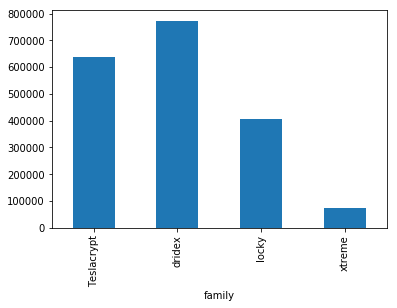

In [19]:
df_imputed['InitializedDataSize'] = pd.to_numeric(df_imputed['InitializedDataSize'])
df_plot = df_imputed.groupby(['family'])['InitializedDataSize'].mean()

df_plot.plot.bar()

print df_imputed.groupby(['family'])['InitializedDataSize'].mean()

### Feature vectorization - for different type of features


- #### For extracting n-grams or text features, you can look into scikit-learn's methods: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


In [2]:
from collections import defaultdict

def get_ngrams_dict(text, n):
    ngrams = defaultdict(int)
    for i in range(len(text)):
        ngrams[text[i:i+n]] += 1
    
    return ngrams
    

In [3]:
get_ngrams_dict('0x7e4a', 2)

defaultdict(int, {'0x': 1, '4a': 1, '7e': 1, 'a': 1, 'e4': 1, 'x7': 1})

In [4]:
get_ngrams_dict('0x5c70', 2)

defaultdict(int, {'0': 1, '0x': 1, '5c': 1, '70': 1, 'c7': 1, 'x5': 1})

In [5]:
get_ngrams_dict('0x4f400', 2)

defaultdict(int,
            {'0': 1, '00': 1, '0x': 1, '40': 1, '4f': 1, 'f4': 1, 'x4': 1})

In [46]:
# N grams for hexadecimal entry point

from collections import Counter
import operator 

md5s = df_imputed['md5'].tolist()
targets = ['297529814d8d292594a1981fad30daa6','a30863f1a404bc2f735cc9ad862e85a9','2e0c328aae6abfb19bf02e0fbc5dea93']

index = 0
for m in md5s:
    if(m == targets[0]):
        fd0 = index
    elif(m == targets[1]):
        fd1 = index
    elif(m==targets[2]):
        fd2 = index
    index += 1
# print fd0
# print fd1
# print fd2
found = []
# found.append(fd0)
# found.append(fd1)
found.append(fd2)
print found
data_hex = df_imputed['EntryPoint'].tolist()
# print len(data_hex)
ngrams_dict = defaultdict(int)
# for i in range(len(data_hex)):
for i in found:
    data_hex[i] = (data_hex[i])[2:]
    print data_hex[i]
    ngrams_curr = get_ngrams_dict(data_hex[i], 2)
#     print ngrams_curr
    input = [ngrams_dict, ngrams_curr]
    ngrams_dict = sum((Counter(ng) for ng in input),  Counter())
# print ngrams_dict
sorted_ngrams = sorted(ngrams_dict.items(), key=operator.itemgetter(1))[:10]
print sorted_ngrams
# Take the first 10  most frequent n grams and make them binary features



[10]
4f400
[(u'4f', 1), (u'0', 1), (u'00', 1), (u'f4', 1), (u'40', 1)]
